Enter the number of estimators (default=100):  34
Enter the maximum depth (default=None):  25


Best parameters: {'max_depth': 25, 'n_estimators': 34}
Best score: -0.0012880435409457916
Mean Squared Error: 0.0053866955017301005


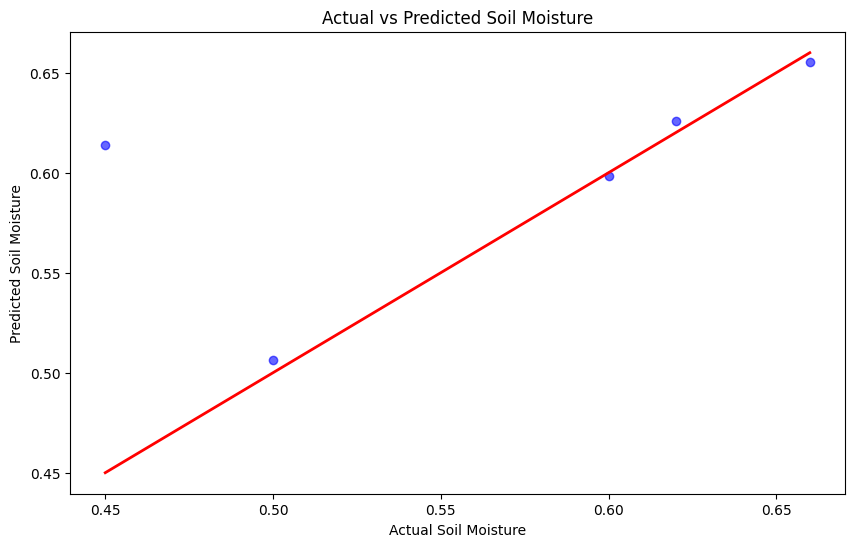

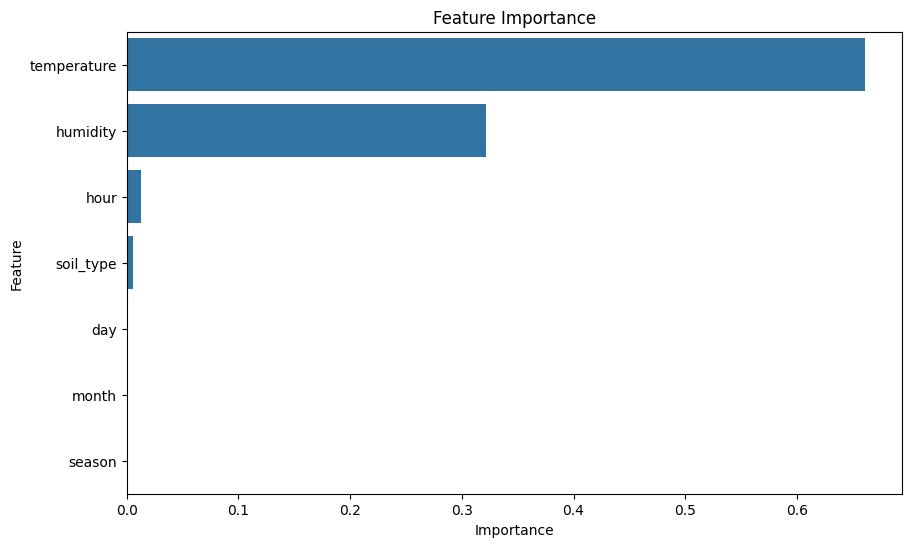

Enter the number of estimators for bagging (default=5):  86


Mean Squared Error (Bagging): 0.0038817029896455655


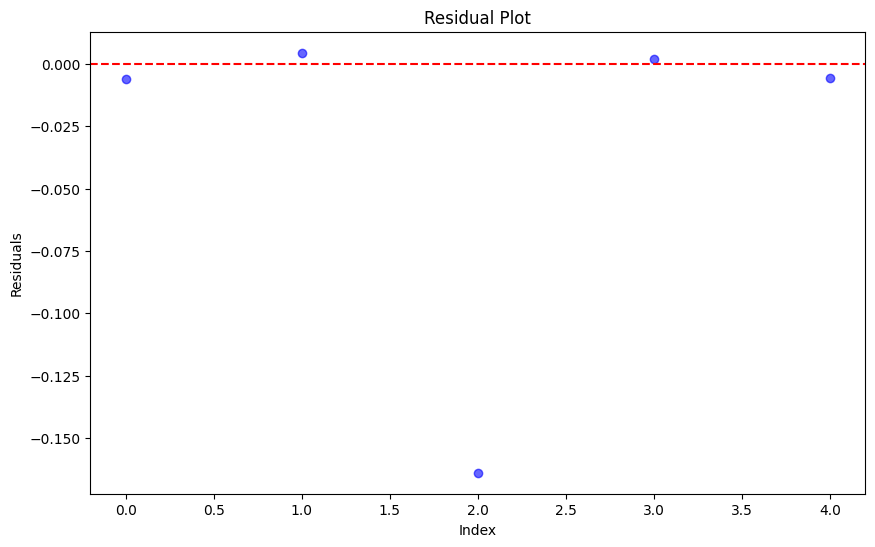

Cross-validation scores (MSE): [2.28421280e-03 4.61072664e-05 8.14857266e-04 2.06907439e-03
 1.45804498e-03]
Mean cross-validation score (MSE): 0.0013344593425605562


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv('historical_data.csv')


data['timestamp'] = pd.to_datetime(data['timestamp'])


data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month


data['season'] = data['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall')


le = LabelEncoder()
data['season'] = le.fit_transform(data['season'])


data = data.drop('timestamp', axis=1)


X = data.drop('soil_moisture', axis=1) 
y = data['soil_moisture'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


n_estimators = int(input("Enter the number of estimators (default=100): ") or 100)
max_depth = input("Enter the maximum depth (default=None): ")
max_depth = int(max_depth) if max_depth else None


param_grid = {'n_estimators': [n_estimators], 'max_depth': [max_depth]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


model = RandomForestRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linewidth=2)
plt.xlabel('Actual Soil Moisture')
plt.ylabel('Predicted Soil Moisture')
plt.title('Actual vs Predicted Soil Moisture')
plt.show()


feature_importances = model.feature_importances_
features = X.columns


importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


n_estimators_bagging = int(input("Enter the number of estimators for bagging (default=5): ") or 5)


bagging_model = BaggingRegressor(RandomForestRegressor(n_estimators=n_estimators, random_state=42), n_estimators=n_estimators_bagging)
bagging_model.fit(X_train, y_train)


y_pred_bagging = bagging_model.predict(X_test)


mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Mean Squared Error (Bagging): {mse_bagging}")


plt.figure(figsize=(10, 6))
residuals = y_test - y_pred  
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='b')  
plt.axhline(0, color='red', linestyle='--')  
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


print(f"Cross-validation scores (MSE): {-cross_val_scores}")
print(f"Mean cross-validation score (MSE): {-cross_val_scores.mean()}")
